# Project Overview

Our client had been analysing their customer feedback, and one thing in particular came up a number of times.

Their customers are aware that they have a great range of competitively priced products in the clothing section - but have said they are struggling to find the products they are looking for on the website.

They are often buying much more expensive products, and then later finding out that we actually stocked a very similar, but lower-priced alternative.

Based upon our work for them using a Convolutional Neural Network, they want to know if we can build out something that could be applied here.

## import packages

In [3]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from os import listdir
from sklearn.neighbors import NearestNeighbors # we will use this functionality to calculate
# cosigned difference between our search image and all of our base images to get a feel for which are
# more similar and which are less similar
import matplotlib.pyplot as plt
import pickle # we wanna save objects so that we can run search engine anytime


## bring in pre-trained model (excluding top)

In [4]:
# image parameters

# we are again going to bring in VGG16 and again we are not going to bring in the top of the network. In other
# words, we only want the network upto the pooling layer as this is where our features come from
# we don't actually care that this VGG16 network was used originally to classify 1000 different images
# just like last time, we are only interested in the features that it learned along the way
# since we are using VGG16 specifically. Let's set up some parameters so it works as it wants to

img_width = 224
img_height = 224
num_channels = 3


In [5]:
# network architecture 
vgg = VGG16(input_shape=(img_width,img_height,num_channels),include_top = False,pooling='avg')
# pooling = none, means the final layer will be a max pooling layer. So this will be in form of number of pooled
# feature maps. For this particular task we don't want that. we instead want a single set of numbers to represent
# all of those features. So if we had pooling = 'avg', it will mean something called global average pooling will be
# applied to that final layer and thus the output of the model will essentially be one array of numeric information
# rather than many arrays. This is what we want.

In [6]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Normally if we did not add that last parameter pooling = 'avg'. Then the final layer would be this below
"  block5_pool (MaxPooling2D)  (None, 7, 7, 512)         0   "
of shape (7,7,512). Instead the global avg pooling logic was at it and this means we get this single array as the output and it is of size 512. So all of these feature maps have been summarized down to one vector of 512 numbers

For each image, these numbers will represent the features and these feature vector is what we will be using to compare our images and assess their similarities but more on that later.

Right now we want to head back to our code and create overall model object and since we are using the keras functional API. We want to put model and within specify input and the output.



In [7]:
model = Model(inputs = vgg.input, outputs = vgg.layers[-1].output)

# we used square brackets with - 1 and .output to denote that our output the one that we want is the final layer
# of our vgg object

In [8]:
# save our model

model.save('models/vgg16_search_engine.h5')

# we save our model so that we could access it whenever we needed it 
# In past tutorials, where we have been specifically training our model. we have used the modelcheckpoint callbag
# to do this, but here we just want to save it manually 

So in high level, there are two things to do to create our search engine from this point. We need to preprocess our images so they are ready to be passed through the model and then we need to do just that feed in our images that returned at output of numeric information that represents each image.

Having this information for all of our base images and any search images means we can compare them and find them which are most similar. We will ofcourse need to set up some functionalities to undertake these steps and we will start that in the next tutorial.

# preprocessing & featurising functions

We are building image search engine driven by deep learning. In the last tutorial we imported everything that we needed and we brought in the pre-trained VGG16 network with one small addition and that was to add a global logic pooling layer at the end. So the output for each image that is passed through will be a single vector containing 512 numerical values that represent all of the features. 

In this tutorial we are gonna set up everything we need inorder to 

A) preprocess our images so that they are in the format of both keras and VGG16 network need

B) featurize our images which in essence would be the process of passing the images into the model and receiving the feature vector as an output.

So let's do this and you'll be very happy to know we build exactly what is needed for preprocessing steps and for other steps where we extract the features of each image we have something that pretty easiy we can modify

In [14]:

def preprocess_image(filepath):
    image = load_img(filepath,target_size=(img_width,img_height))
    image = img_to_array(image)
    image = np.expand_dims(image,axis=0)
    image = preprocess_input(image)
    
    return image

In [15]:
# featurize image

def featurise_image(image):
    feature_vector = model.predict(image)    
    return feature_vector

We are not using this function to make predictions. we are instead looking to essentially featurize each image
As remember the output for our network is it stands is'nt an output layer with a number of classes. It is the global average pooling layer that will give us our feature vector and since that is the case we can actually remove these below :

    predicted_class = np.argmax(class_probs)
    predicted_label = labels_list[predicted_class]
    predicted_prob = class_probs[0][predicted_class]

So that is the logic there above in those two functions that we need for both preprocessing and featurising our images

So in next tutorial we will utilize these functions and we will process and featurise all of our 300 base images. As we do this we store all of the output, those feature vectors so they are available to us when the time comes to assess which are most similar to any image that is input into our image search engine.

Last time we quickly created a preprocessing function as well as a simple function that will run what is needed to featurise each image and return the feature vector. Here we will utilise these functions and we will process and featurise all of our 300 base images and we will store all of those feature vectors so that they are available to us when the time comes to assess which are most similar to any image that is input to our image search engine. So let's do this. Let's start by specifying the source directory where our images are stored 

In [19]:
# source directory for base images

source_dir = '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/'


In [20]:
filename_store = []
feature_vector_store = np.empty((0,512))


In [21]:
# pass in & featurise base image set

# we wanna bring the images, preprocess them, featurise them and then append both the filename and feature vector
# to the empty objects we just created 

for image in listdir(source_dir):
    
    print(image)
    
    # append image filename for future lookup
    filename_store.append(source_dir + image)
    
    # preprocess the image
    preprocessed_image = preprocess_image(source_dir + image)
    
    # extract the feature vector
    feature_vector = featurise_image(preprocessed_image)
    
    # append feature vector for similarity calculations
    feature_vector_store = np.append(feature_vector_store,feature_vector,axis=0)
    

footwear_0070.jpg


2023-07-08 15:15:09.773117: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 298ms/step
footwear_0064.jpg
1/1 [==============================] - 0s 10ms/step
footwear_0058.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0299.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0272.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0266.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0104.jpg
1/1 [==============================] - 0s 10ms/step
footwear_0110.jpg
1/1 [==============================] - 0s 10ms/step
footwear_0138.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0139.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0111.jpg
1/1 [==============================] - 0s 10ms/step
footwear_0105.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0267.jpg
1/1 [==============================] - 0s 11ms/step
footwear_0273.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0298.jpg
1/1 [======================

1/1 [==============================] - 0s 10ms/step
footwear_0002.jpg
1/1 [==============================] - 0s 10ms/step
footwear_0228.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0214.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0200.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0189.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0162.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0176.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0177.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0163.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0188.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0201.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0215.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0229.jpg
1/1 [==============================] - 0s 9ms/step
footwear_0003.jpg
1/1 [===========================

So it takes time to run remember we are passing each of 300 images right through that whole initial section of VGG16 with all of the convolutional and pooling layer. So there is a lot to be done each time

Anyway we are now at the stage where all 300 base images have now been processed. So we should have a filename store list with 300 image file paths and we should have a feature vector store object which contains a 512 length feature vector for all 300 images as well.

Now to ensure we don't need to run all of that each time. Let's save those to objects using pickle. This will mean that we can pick them up and use them again whenever we want to run a search of our image database

In [32]:
# save key objects for future_use

pickle.dump(filename_store,open('/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/models/filename_store.p','wb'))
# wb = writing this object to our hard drive
pickle.dump(feature_vector_store,open('/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/models/feature_vector_store.p','wb'))


Now the objects are stored as pickle files. We can bring in whenever we need and we will be needing them for the next tutorial and this is the big one.

We will be sending a search image in, preprocessing it, featurising it and then comparing that to our database of already featurised base images. 

After which we will return some specified number of most similar results

So far we have brought in the VGG16 model in a way that works for us here. We've created the logic needed to both preprocess and featurise our data and then we put those into place and featurised our base set of 300 images.

Now we are at the combination of at all, where we will put in place the logic for search engine itself. We will pass in a image that is not part of the base images so this will represent the image that the customer would put into the website. This image will be preprocessed, featurised and then compared to our set of featurised base images in a specified number of best matching results will be returned.

Now in reality this piece of code that we are writing here would'nt sit in the same script as the rest of the logic. Each time we wanted to process a search script. we would certainly not want to have everything that we've done here especially not featurising the images themselves as no customer would be happy waiting 10 minutes for the results to come back, but for the purposes of illustration I would keep it all in one place here where we can talk more about the considerations around this at the end, but for now let's just get up everything running.

And to somewhat limit the fact we would'nt run everything again, Let's start by importing the model file

## pass in new image, and return similar images

In [35]:
# load in required objects

model = load_model('/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/models/vgg16_search_engine.h5',compile=False)

#compile = false means we avoid a warning message. Compiling a model really just setting it up for training
# and since we are not training it here. We don't actually need to do this but like I say If we did just leave the
# load_model functionality to its default parameter values it would have compile = True and we will get a warning
# saying this model is not yet compiled


# lets bring in file name store and feature vector store

filename_store = pickle.load(open('/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/models/filename_store.p','rb'))
feature_vector_store = pickle.load(open('/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/models/feature_vector_store.p','rb'))


In [36]:
# search parameters

# we need to set parameters for our search query, namely how many search results we want to be returned

search_results_n = 8

# this means when we feed in a search image, the 8 closest image or most similar images from our base set will be 
# returned . The other thing we will need is to specify the filepath for the search image itself

search_image = 'search_image_01.jpg'


In [38]:
# preprocess & featurise search image

# so just like we did for all of our base images. Our search image will need to be preprocessed and featurised

preprocessed_image = preprocess_image(search_image)
search_feature_vector = featurise_image(preprocessed_image)

# at this point we have our search image existing as a 512 length feature vector and we need to compare that feature
# vector to the feature vectors of all of our base images. From there we need to understand which of those base image
# feature vectors are most like the feature vector of our search image and more specifically we need to return the
# 8 most closely matched as that is what we specified above 

# To do this we are going to use the nearest neighbours class from scikit learn 


1/1 [==============================] - 0s 96ms/step


In [42]:
# instantiate nearest neighbours logic

image_neighbours = NearestNeighbors(n_neighbors = search_results_n, metric = 'cosine')



We will apply the cosigned distance metric to calculate the angle of difference between the feature vectors 
So cosine distance essentially measures the angle between any two vectors. In other words it looks to easy whether
the two vectors are pointing in a similar direction or not. The more similar the direction the vectors are pointing
the smaller the angle between them in space and more different the direction the larger the angle between them in
space . This angle gives us cosigned distance score

By calculating this score between our search image vector and each of our base image vectors. We can be returned the images with 8 lowest cosign scores and these will be our 8 most similar images. Atleast in terms of the feature
vector representation that comes from a VGG16 network 

In [43]:
# apply to our feature vector store

image_neighbours.fit(feature_vector_store)

NearestNeighbors(metric='cosine', n_neighbors=8)

In [45]:
# return search results for search image (distances & indices)

image_distances, image_indices = image_neighbours.kneighbors(search_feature_vector)


this is the backbone of our search image processing
if we pass our search feature vector into our imageneighbours object, it will return us two things. 

A) It will find the eight nearest base feature vectors and for each it will return eight cosine distance

B) the index of that feature vector from our feature_vector_store which contains all 300 of our base images

These will be super useful as it will not only allow us to understand how similar each of the eight cosine images are but it will allow us a nice easy way to access them, so we can return those images and take a loot ourselves



In [46]:
image_distances
# you can see below we are returned an array of 8 numbers and these correspond to the cosine distance for those
# 8 most similar images and they are in order of smallest to largest or in other words most similar to least 
# similar. If we do the same with our image indices object

array([[0.11272611, 0.15720025, 0.19085656, 0.20477758, 0.21775484,
        0.23059241, 0.2458289 , 0.25736065]])

In [47]:
image_indices
# we can see which of our 300 images were our closest eight and these are in same order as the distances we
# just saw
# for example : image with 164 is our most similar image and image with 148 is our second most similar image 
# so on and so on and so on....

array([[164, 148, 125, 131,  45,  47, 157, 270]])

In [48]:
# convert closest image indices & distances to lists
image_indices = list(image_indices[0])
image_distances = list(image_distances[0])


Now we plot these 8 similar images on matplotlib so we can take a look at them and hopefully marvel at how well
our image search engine is done.

before we actually go in and do this, we need to convert both our closest distances and indices to be list
as this will make things a lot easier for us in the next steps

We got these converted into list, but what we really need if we want to show the actual images themselves are the filenames for those closest images. Since we have the index values for them we can apply these to our filenames store object and we will be returned a list of the filenames of those 8 closest images and this will mean we can import those files and display them here in python

In [53]:
# get list of filenames for search results
search_results_file = [filename_store[i] for i in image_indices]


In [54]:
search_results_file
# so we now have a list of files for the eight most similar images. So let's now use matplotlib


['/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0187.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0231.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0176.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0229.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0301.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0261.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0186.jpg',
 '/Users/praju/Desktop/DSI/Deep_Learning/Image Search Engine/data/footwear_0268.jpg']

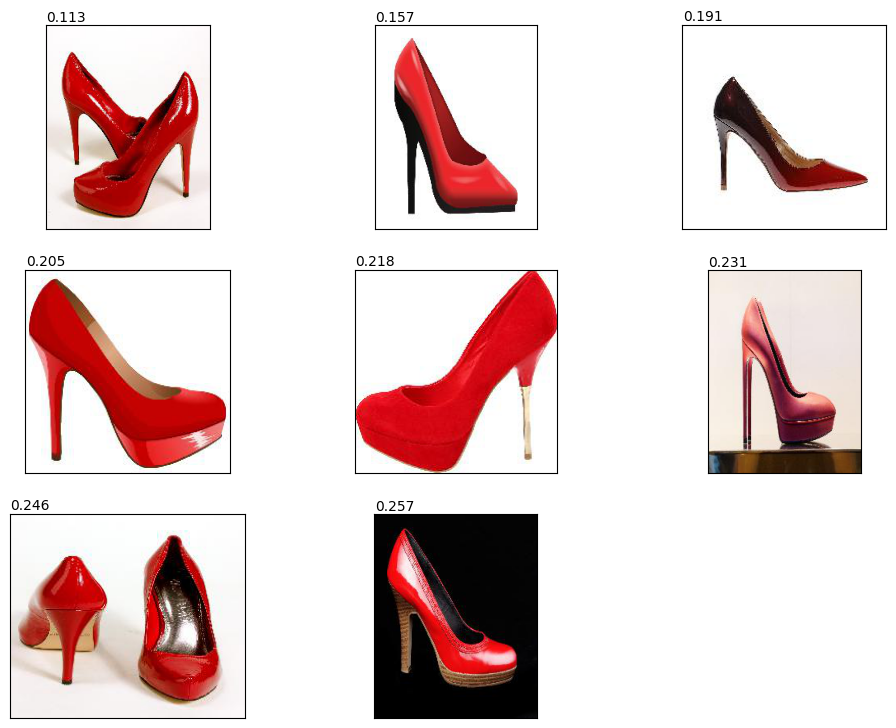

In [56]:
# plot search results

plt.figure(figsize=(12,9))
for counter, result_file in enumerate(search_results_file):    
    image = load_img(result_file)
    ax = plt.subplot(3, 3, counter+1)
    plt.imshow(image)
    plt.text(0, -5, round(image_distances[counter],3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

So at the very top we set a figure size
then as you can see a for loop in place, this will iterate most of our similar images in that search result files and plot them one by one onto our figure and as you can see we are using this enumerate meaning we can access a counter of which iteration we are in and in this particular case this is really useful as we can use it to ensure that our images are plotted in nice columns and rows. you'll see what i mean in a minute

Next for each of those image filenames we want to import it and we are just using keras as load image functionality like we've done before . After that for each of the 8 images we are actually going to plot them all on the same figure like i mentioned a second ago and we will do this using subplot. Since we are plotting 8 images in total. I've just chosen to make the final plot a 3x3 grid which will give us a nice squared plot at the end

Actually what is good to mention is the logic of this subplot functionality. In this parenthesis, we have 3,3,counter + 1. These stand for number of rows in overall plot, the number of columns and the index of the subplot
Then we use the counter object that we named when using the enumerate logic to make this happen.

After that we tell matplotlib to plot each of the images on to the figure and we use this using plt.imshow. Then this next line of code here this plt.text allows us to right on to our plot . The reason i've added this so that we won't only plot the most similar images themselves but so we can also see the cosine distance score for each and again to explain what is going on in this line and specifically within the parenthesis we have x-coordinate first and y-coordinate so where we want the text to be placed on each of the subplots and then we are specifying what we want the text to be. Our distances are float values with lot of decimal places. so I am just using round and passing in our image distances object . Then the matplotlib knows which distance to plot each time I'm just using the index from our counter and then I'm specifying to round these numbers to 3 decimal places . So that will add the text and you will see what I mean when we run this and then after that we have these two lines:

ax.get_xaxis().set_visible(False)

ax.get_yaxis().set_visible(False)

The above lines are just to remove the axis from these plots. so instead of having lines and tick marks on x and y-axis we just want the images themselves that is what these lines do. Then the very last thing and that is plt.show()
and this will just instruct matplotlib to go ahead and show all of the subplots together on the overall plot 


So looking at the plot images, this is really good and I am super impressed.
So what we have here is 8 images from our base set that the network has deemed to be most similar based upon the cosine difference between the feature vectors and you can actually see those scores here as well. Along the top left of each of the image is that cosine similarity score and while it is a bit difficult to give them a huge amount of context as just a number. It could be very useful information to have for this project in the real world. So there would be cases where the most similar image was still not that similar. It would still be returned based upon how logic here but a company could always apply some extra logic which says something like we only return similar images if the cosine similarity score is below say 0.4 for example or perhaps we could add some sort of similarity tag that the user can see. So very similar products vs moderately similar. These are just some ideas of top my head but hopefully you can see where I'm coming from .

So before we wrap up here, we should really go and try our other test images as well and ofcourse you can test this with any image you like but ofcourse keep in mind we are using a pretty small base set of images here.

All right to try search **image number 2**.
    
  


In [57]:
search_image = 'search_image_02.jpg'
search_results_n = 8

preprocessed_image = preprocess_image(search_image)
search_feature_vector = featurise_image(preprocessed_image)

image_distances, image_indices = image_neighbours.kneighbors(search_feature_vector)

image_indices = list(image_indices[0])
image_distances = list(image_distances[0])

search_results_file = [filename_store[i] for i in image_indices]

1/1 [==============================] - 0s 15ms/step


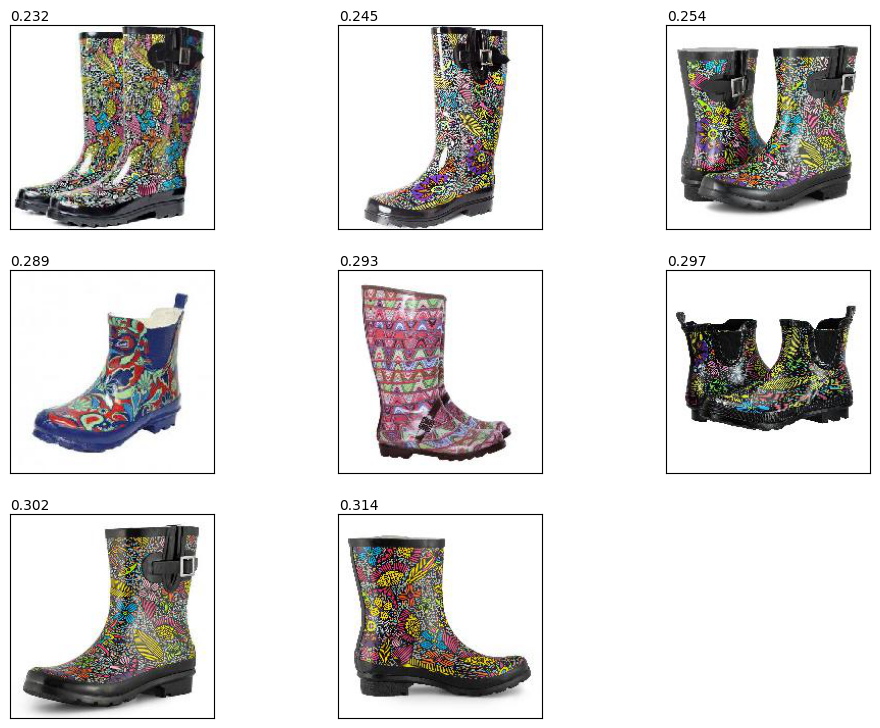

In [58]:
# plot results

plt.figure(figsize=(12,9))
for counter, result_file in enumerate(search_results_file):    
    image = load_img(result_file)
    ax = plt.subplot(3, 3, counter+1)
    plt.imshow(image)
    plt.text(0, -5, round(image_distances[counter],3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Again, these have come out really well - the features from VGG16 combined with Cosine Similarity have done a great job!